# Representation Scenarios and Modeling Comparisons

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("C:/Users/smrit/OneDrive/Desktop/DTSC 3602/DTSC_3602/Project/Datasets/Crime Data/Crime_Data_from_2020_to_Present.csv", low_memory=False)
cols = ['AREA NAME', 'Crm Cd Desc', 'Vict Sex', 'Vict Age', 'LAT', 'LON']
df = df[cols].dropna()
df = df[df['Vict Sex'].isin(['M', 'F'])]
df = df.sample(10000, random_state=42)

y = df['Vict Sex']

In [7]:
# Baseline Representation
X_base = df.drop(columns=['Vict Sex'])
X_base = X_base.apply(lambda col: LabelEncoder().fit_transform(col.astype(str)) if col.dtype == 'object' else col)
X_train_b, X_test_b, y_train, y_test = train_test_split(X_base, y, test_size=0.3, random_state=42)

In [8]:
# Improved Representation
X_imp = df.copy()
bins = [0, 18, 30, 50, 70, 120]
labels = ['Under18', '18-30', '30-50', '50-70', '70+']
X_imp['AgeGroup'] = pd.cut(X_imp['Vict Age'], bins=bins, labels=labels, right=False)
X_imp = X_imp.drop(columns=['Vict Age'])
X_imp = pd.get_dummies(X_imp, drop_first=True)
scaler = StandardScaler()
num_cols = X_imp.select_dtypes(include=['float64', 'int64']).columns
X_imp[num_cols] = scaler.fit_transform(X_imp[num_cols])
X_train_i, X_test_i, _, _ = train_test_split(X_imp, y, test_size=0.3, random_state=42)

In [9]:
def evaluate_models(X_train, X_test, y_train, y_test, label):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=500),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, pos_label='M')
        rec = recall_score(y_test, y_pred, pos_label='M')
        f1 = f1_score(y_test, y_pred, pos_label='M')
        male_acc = accuracy_score(y_test[y_test=='M'], y_pred[y_test=='M'])
        female_acc = accuracy_score(y_test[y_test=='F'], y_pred[y_test=='F'])
        fairness_gap = abs(male_acc - female_acc)
        results.append({
            'Scenario': label, 'Model': name,
            'Accuracy': round(acc,3), 'Precision': round(prec,3),
            'Recall': round(rec,3), 'F1': round(f1,3), 'Fairness_Gap': round(fairness_gap,3)
        })
    return pd.DataFrame(results)
baseline_results = evaluate_models(X_train_b, X_test_b, y_train, y_test, 'Baseline')
improved_results = evaluate_models(X_train_i, X_test_i, y_train, y_test, 'Improved')
results = pd.concat([baseline_results, improved_results])
print(results)

   Scenario                Model  Accuracy  Precision  Recall     F1  \
0  Baseline  Logistic Regression     0.534      0.546   0.720  0.622   
1  Baseline        Decision Tree     0.576      0.603   0.590  0.596   
2  Baseline        Random Forest     0.587      0.609   0.618  0.613   
0  Improved  Logistic Regression     1.000      1.000   1.000  1.000   
1  Improved        Decision Tree     1.000      1.000   1.000  1.000   
2  Improved        Random Forest     1.000      1.000   1.000  1.000   

   Fairness_Gap  
0         0.397  
1         0.031  
2         0.067  
0         0.000  
1         0.000  
2         0.000  


In [10]:
# Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_i, y_train)
importances = pd.Series(rf.feature_importances_, index=X_train_i.columns).sort_values(ascending=False)
print('Top 5 Important Features (Improved Representation):')
print(importances.head(5))

Top 5 Important Features (Improved Representation):
Vict Sex_M                                                    0.871342
LAT                                                           0.026461
LON                                                           0.024098
Crm Cd Desc_INTIMATE PARTNER - SIMPLE ASSAULT                 0.009216
Crm Cd Desc_ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    0.005573
dtype: float64


# Data Integration and Cleaning Notebook 

In [11]:
import pandas as pd

crime= pd.read_csv("C:/Users/smrit/OneDrive/Desktop/DTSC 3602/DTSC_3602/Project/Datasets/Crime Data/Crime_Data_from_2020_to_Present.csv")
ext = pd.read_csv("C:/Users/smrit/OneDrive/Desktop/DTSC 3602/DTSC_3602/Project/Datasets/Household Income/Dataset.csv")

crime.head()
ext.head()

,GEO_ID,NAME,S1903_C01_001E,S1903_C01_001M,S1903_C01_002E,S1903_C01_002M,S1903_C01_003E,S1903_C01_003M,S1903_C01_004E,S1903_C01_004M,...,S1903_C03_036E,S1903_C03_036M,S1903_C03_037E,S1903_C03_037M,S1903_C03_038E,S1903_C03_038M,S1903_C03_039E,S1903_C03_039M,S1903_C03_040E,S1903_C03_040M
0,Geography,Geographic Area Name,Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...,Margin of Error!!Number!!HOUSEHOLD INCOME BY R...,Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...,Margin of Error!!Number!!HOUSEHOLD INCOME BY R...,Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...,Margin of Error!!Number!!HOUSEHOLD INCOME BY R...,Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...,Margin of Error!!Number!!HOUSEHOLD INCOME BY R...,...,Estimate!!Median income (dollars)!!NONFAMILY H...,Margin of Error!!Median income (dollars)!!NONF...,Estimate!!Median income (dollars)!!NONFAMILY H...,Margin of Error!!Median income (dollars)!!NONF...,Estimate!!Median income (dollars)!!NONFAMILY H...,Margin of Error!!Median income (dollars)!!NONF...,Estimate!!Median income (dollars)!!NONFAMILY H...,Margin of Error!!Median income (dollars)!!NONF...,Estimate!!Median income (dollars)!!NONFAMILY H...,Margin of Error!!Median income (dollars)!!NONF...
1,0400000US06,California,13103114,18542,8140180,16772,806733,4977,97757,2048,...,35763,369,85485,1199,58781,539,47507,583,95953,1000
2,1600000US0600135,"Acalanes Ridge CDP, California",348,105,303,93,0,13,0,13,...,-,**,-,**,-,**,-,**,-,**
3,1600000US0600156,"Acampo CDP, California",131,139,131,139,0,13,0,13,...,-,**,-,**,-,**,-,**,-,**
4,1600000US0600212,"Acton CDP, California",2584,195,2206,182,6,9,21,26,...,23750,15734,-,**,48750,15022,52545,13282,36607,35128


In [12]:
crime.shape
ext.shape

(1613, 242)

In this step, both datasets were loaded and we looked at the structure to find our key variables. The mean and median household income estimate can help us with demographics when looking at crime patterns.

In [13]:
ext['geoid_clean'] = ext['GEO_ID'].str[-11:]
ext['geoid_clean'] = ext['geoid_clean'].str.replace("US","", regex =False)

ext[['GEO_ID', 'geoid_clean']].head()

,GEO_ID,geoid_clean
0,Geography,Geography
1,0400000US06,040000006
2,1600000US0600135,000600135
3,1600000US0600156,000600156
4,1600000US0600212,000600212


In this step, we cleaned the data to just include the tract code so it is useful for future merges.

In [14]:
acs = ext.rename(columns={
    "S1903_C01_001E" : "median_income",
    "S1903_C02_001E" : "mean_income"
})

acs = acs[['geoid_clean', 'NAME', 'median_income', 'mean_income']]
acs.head()

,geoid_clean,NAME,median_income,mean_income
0,Geography,Geographic Area Name,Estimate!!Number!!HOUSEHOLD INCOME BY RACE AND...,Estimate!!Percent Distribution!!HOUSEHOLD INCO...
1,040000006,California,13103114,13103114
2,000600135,"Acalanes Ridge CDP, California",348,348
3,000600156,"Acampo CDP, California",131,131
4,000600212,"Acton CDP, California",2584,2584


In [22]:
acs["median_income"] = pd.to_numeric(acs["median_income"], errors = "coerce")
acs["mean_income"] = pd.to_numeric(acs["mean_income"], errors= "coerce")

acs = acs.dropna(subset=["median_income", "mean_income"], how="all")
acs.isnull().sum()

geoid_clean      0
NAME             0
median_income    0
mean_income      0
dtype: int64

In this step, our key variables were renamed and checked for missing values (none found). 

In [24]:
crime_div= crime.groupby("AREA NAME").size().reset_index(name= "crime_count")
avg_crime = crime_div["crime_count"].mean()

acs_summary = acs.agg({"median_income": "mean", "mean_income": "mean"}).to_frame().T
acs_summary["key"] = 1
crime_div["key"] = 1


merged = crime_div.merge(acs_summary,on="key").drop(columns="key")
merged.head()

,AREA NAME,crime_count,median_income,mean_income
0,77th Street,61758,15885.040943,15885.040943
1,Central,69670,15885.040943,15885.040943
2,Devonshire,41756,15885.040943,15885.040943
3,Foothill,33133,15885.040943,15885.040943
4,Harbor,41394,15885.040943,15885.040943


In this step, the key variables in the external dataset were summarized, cleaned up, and the datasets were merged. 

In [26]:
merged["income_per_crime"] = merged["median_income"] / merged["crime_count"]
merged["crime_density"] = merged["crime_count"] > avg_crime

merged.head()

,AREA NAME,crime_count,median_income,mean_income,income_per_crime,crime_density
0,77th Street,61758,15885.040943,15885.040943,0.257214,True
1,Central,69670,15885.040943,15885.040943,0.228004,True
2,Devonshire,41756,15885.040943,15885.040943,0.380425,False
3,Foothill,33133,15885.040943,15885.040943,0.479433,False
4,Harbor,41394,15885.040943,15885.040943,0.383752,False


The new features that were made include: income_per_crime (median income/ crime_count) and crime_density (crime_count > avg.crime). Areas with lower income may not have as may responding police officers, which could affect reports. Crime density is also important for fairness because areas with more crime than the average will require more police officers.

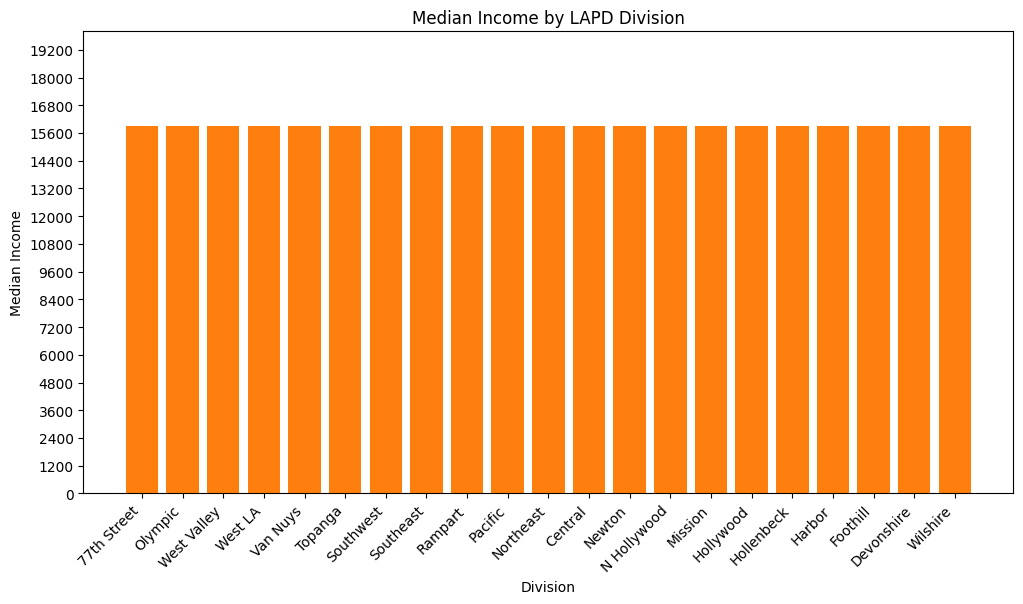

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,6))

sorted_data=merged.sort_values("median_income", ascending=False)
bars = plt.bar(sorted_data["AREA NAME"], sorted_data["median_income"])

plt.bar(merged["AREA NAME"], merged["median_income"])
plt.title("Median Income by LAPD Division")
plt.xlabel("Division")
plt.ylabel("Median Income")
plt.ylim(0, 20000)
plt.yticks(ticks=range(0, 20000, 1200))

plt.xticks(rotation=45, ha='right')

plt.show()